# Fabric Defect Detector with tensorflow object detection

## Dependencies

In [ ]:
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim
!pip install pycocotools

In [3]:
#cd models/research/
!sudo protoc object_detection/protos/*.proto --python_out=.

[sudo] password for saad: 


### Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util


In [2]:
tf = tf.compat.v1
tf.gfile = tf.io.gfile

In [3]:
PATH_TO_LABELS = 'object_detection/images/labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [4]:
category_index

{1: {'id': 1, 'name': 'Stain'}, 2: {'id': 2, 'name': 'Hole'}}

In [19]:
import pathlib
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('validation/')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('validation/301.jpg')]

In [6]:
#detection_model = tf.saved_model.load('object_detection/new_graph/saved_model')

detection_model = tf.compat.v2.saved_model.load(str('object_detection/latest/saved_model'), None)

In [ ]:
import os
from flask import Flask, render_template, request, redirect, url_for, send_from_directory
from werkzeug import secure_filename
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tensorflow as tf
from collections import defaultdict
from io import StringIO
from PIL import Image


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

app = Flask(__name__)

app.config['UPLOAD_FOLDER'] = 'uploads/'
app.config['ALLOWED_EXTENSIONS'] = set(['png', 'jpg', 'jpeg'])

def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1] in app.config['ALLOWED_EXTENSIONS']


@app.route('/')
def index():
    return render_template('index.html')


@app.route('/upload', methods=['POST'])
def upload():
    file = request.files['file']
    if file and allowed_file(file.filename):
        filename = secure_filename(file.filename)
        file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))
        return redirect(url_for('uploaded_file',
                                filename=filename))


@app.route('/uploads/<filename>')
def uploaded_file(filename):
    PATH_TO_TEST_IMAGES_DIR = app.config['UPLOAD_FOLDER']
    TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR,filename.format(i)) for i in range(1, 2) ]
    IMAGE_SIZE = (12, 8)

    # with detection_graph.as_default():
    #     with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
        image = Image.open(image_path)
        image_np = load_image_into_numpy_array(image)
        image_np_expanded = np.expand_dims(image_np, axis=0)
       
        input_tensor = tf.convert_to_tensor(image)
        input_tensor = input_tensor[tf.newaxis,...]

        model_fn = detection_model.signatures['serving_default']
        output_dict = model_fn(input_tensor)

        # image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # scores = detection_graph.get_tensor_by_name('detection_scores:0')
        # classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = int(output_dict.pop('num_detections'))
       
        output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
        output_dict['num_detections'] = num_detections
        output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
        if 'detection_masks' in output_dict:
            detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(output_dict['detection_masks'], output_dict['detection_boxes'],image.shape[0], image.shape[1])      
            detection_masks_reframed = tf.cast(detection_masks_reframed > 0.8,tf.uint8)
            output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
        # (boxes, scores, classes, num_detections) = sess.run(
        #     [boxes, scores, classes, num_detections],
        #     feed_dict={image_tensor: image_np_expanded})
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,output_dict['detection_boxes'],output_dict['detection_classes'],output_dict['detection_scores'],category_index,
            instance_masks=output_dict.get('detection_masks_reframed', None),
            use_normalized_coordinates=True,
            line_thickness=8)
        final_score = np.squeeze(output_dict['detection_scores'])    
        im = Image.fromarray(image_np)
        im.save('uploads/'+filename)

    return send_from_directory(app.config['UPLOAD_FOLDER'],
                               filename)
if __name__ == '__main__':
    app.run(debug=True,host='0.0.0.0',port=5000)

Error: Session cannot generate requests

## Detection with images

In [126]:
import cv2
import csv
import easygui

def run_inference_for_single_image(model, image):
  
  image = np.asarray(image)

  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]

  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
  if 'detection_masks' in output_dict:
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

def show_inference(model, image_path):
  global thresholded_value
  thresholded_value = float(easygui.enterbox("Set thresholded value - (0 - 1)"))
  
  image_np = np.array(Image.open(image_path))
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      min_score_thresh=thresholded_value,
      # max_boxes_to_draw=int(easygui.enterbox("Set thresholded value - (1 - anything)")),
      line_thickness=8)
  
  boxes = np.squeeze(output_dict['detection_boxes'])
  scores = np.squeeze(output_dict['detection_scores'])
  bboxes = boxes[scores > thresholded_value]
  width = image_np.shape[1]
  height = image_np.shape[0]
  final_box = []

  for box in bboxes:
    ymin, xmin, ymax, xmax = box
    box_width = (xmax-xmin)*width
    box_height = (ymax-ymin)*height
    box_area  = box_width*box_height
    final_box.append([xmin * width, xmax * width, ymin * height, ymax * height])
  
  count = 0
  hole_count = 0; stain_count = 0  
  for i in range(len(scores)):
      
      if scores[i] > thresholded_value:

          detected_class = int(output_dict['detection_classes'][i])
#           print(output_dict['detection_classes'][i])
          count = count + 1 
          if detected_class == 1:
              stain_count = stain_count + 1
          elif detected_class == 2:    
              hole_count = hole_count + 1
          elif detected_class == 1 and detected_class == 2:    
              hole_count = hole_count + 1
              stain_count = stain_count + 1
          else:
            break
  print('Total Number of defects detected: ',count)    
  print('Total Number of Stains detected: ',stain_count)     
  print('Total Number of Holes detected: ',hole_count)
  print("Detected Co-ordinates: ", final_box)
  print("Area of detected defects: ",round(box_area), "units")

  fault_list = [image_path,'Defects count: {}'.format(count),'Stain Count: {}'.format(stain_count) ,'Hole count: {}'.format(hole_count),'Defected area co-ordinates: {}'.format(final_box),'Total defected Area: {}'.format(box_area) ]
  with open("defect_detector.csv", 'a') as fp:
      wr = csv.writer(fp, dialect='excel')
      wr.writerow(fault_list)

  
  image_np = cv2.putText(image_np, 'Total Number of defects detected:{} '.format(count), (20, 30), cv2.FONT_HERSHEY_SIMPLEX,  
                   1, ((255, 0,0) ), 4, cv2.LINE_AA)     
  image_np_stain = cv2.putText(image_np, 'Total Number of stains detected:{} '.format(stain_count), (20, 170), cv2.FONT_HERSHEY_SIMPLEX,  
                   1, ((255, 0,0) ), 4, cv2.LINE_AA)     
  image_np_hole = cv2.putText(image_np, 'Total Number of holes detected:{} '.format(hole_count), (20, 100), cv2.FONT_HERSHEY_SIMPLEX,  
                   1, ((255, 0,0) ), 4, cv2.LINE_AA)  
  image_np_area = cv2.putText(image_np, 'Area of defect detected:{} '.format(box_area), (20, 240), cv2.FONT_HERSHEY_SIMPLEX,  
                   1, ((255, 0,0) ), 4, cv2.LINE_AA)     
  
  display(Image.fromarray(image_np))  

Total Number of defects detected:  2
Total Number of Stains detected:  2
Total Number of Holes detected:  0
Detected Co-ordinates:  [[1091.3152341842651, 1488.0, 728.2043609619141, 1363.777442932129], [1076.586290359497, 1488.0, 1.9535531997680664, 387.58035469055176]]
Area of detected defects:  158652 units


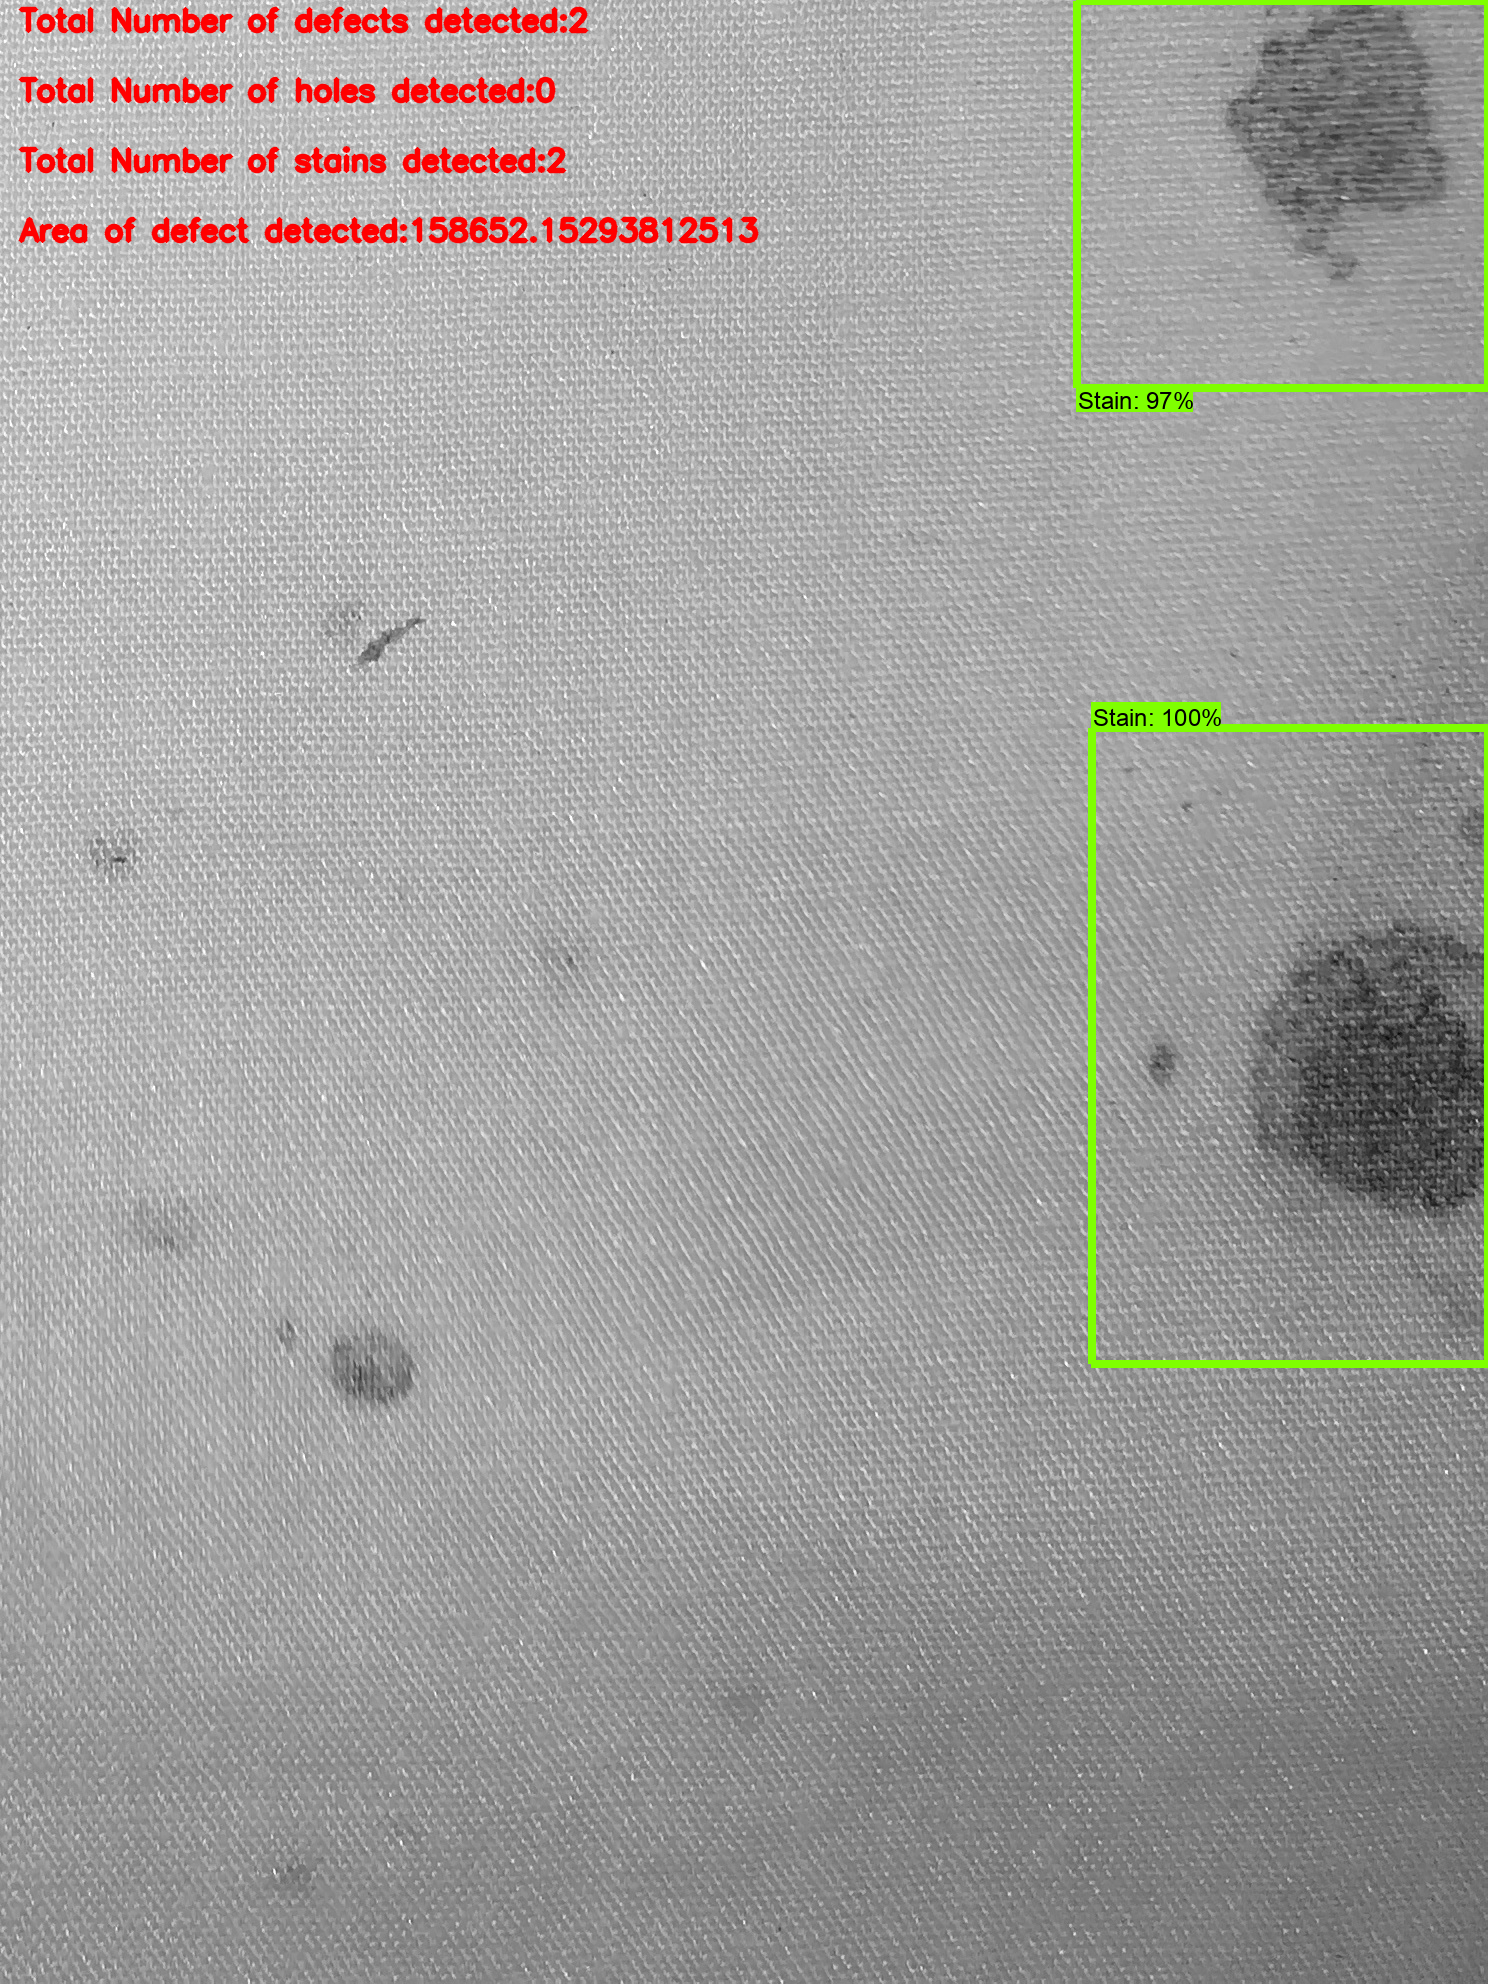

In [137]:
for image_path in TEST_IMAGE_PATHS:
  image_path = easygui.fileopenbox()
  show_inference(detection_model, image_path)


## Detection with Webcam

In [ ]:
import csv

def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]

  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
  if 'detection_masks' in output_dict:
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.7,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict


def show_inference(model, image_np):
  output_dict = run_inference_for_single_image(model, image_np)
  final_img =vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          min_score_thresh = 0.7,
          instance_masks=output_dict.get('detection_masks_reframed', None),
          use_normalized_coordinates=True,
          line_thickness=6)
  
  final_score = np.squeeze(output_dict['detection_scores'])    
  count = 0
  hole_count = 0; stain_count = 0  
  for i in range(len(final_score)):
      
      if final_score[i] is None or final_score[i] > 0.7:
          detected_class = int(output_dict['detection_classes'][i])
#           print(output_dict['detection_classes'][i])
          count = count + 1 
          
          if detected_class == 1:
              stain_count = stain_count + 1
          elif detected_class == 2:    
              hole_count = hole_count + 1
          elif detected_class == 1 and detected_class == 2:    
              hole_count = hole_count + 1
              stain_count = stain_count + 1
          else:
            break
  print('Total Number of defects detected: ',count)    
  print('Total Number of Holes detected: ',hole_count)
  print('Total Number of Stains detected: ',stain_count)      

  fault_list = ['Defects count: {}'.format(count),'Stain Count: {}'.format(stain_count) ,'Hole count: {}'.format(hole_count) ]
  with open("defect_detector_webcam.csv", 'a') as fp:
      wr = csv.writer(fp, dialect='excel')
      wr.writerow(fault_list)
  
  image_np = cv2.putText(image_np, 'Total Number of defects detected:{} '.format(count), (20, 30), cv2.FONT_HERSHEY_SIMPLEX,  
                   0.7, ((255, 0,0) ), 2, cv2.LINE_AA)     
  image_np_hole = cv2.putText(image_np, 'Total Number of holes detected:{} '.format(hole_count), (20, 70), cv2.FONT_HERSHEY_SIMPLEX,  
                   0.7, ((255, 0,0) ), 2, cv2.LINE_AA)     
  image_np_stain = cv2.putText(image_np, 'Total Number of stains detected:{} '.format(stain_count), (20, 110), cv2.FONT_HERSHEY_SIMPLEX,  
                   0.7, ((255, 0,0) ), 2, cv2.LINE_AA)     

  return(final_img)

## Realtime detection with webcam

In [ ]:
import cv2


cap = cv2.VideoCapture(0)

while 1:
    ret,img = cap.read()
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    final_img = show_inference(detection_model,img)
    
    final_img = cv2.cvtColor(final_img,cv2.COLOR_RGB2BGR)

    cv2.imshow('Fabric Defect Detection',final_img)

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


## Realtime Detection with external camera through IP Address

In [ ]:
import requests
import cv2
import numpy as np
import imutils
import urllib
  
url = "http://192.168.0.101:8080/shot.jpg"
  
while True:
    img_arr = np.array(bytearray(urllib.request.urlopen(url).read()),dtype=np.uint8)
    img = cv2.imdecode(img_arr,-1)
    img = imutils.resize(img, width=550, height=100)
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    final_img = show_inference(detection_model,img)
    final_img = cv2.cvtColor(final_img,cv2.COLOR_RGB2BGR)
    cv2.imshow('Fabric Defect Detection',final_img)
    
    if cv2.waitKey(1) == ord('q'):
        break
  
cv2.destroyAllWindows()